Here is the competition link: https://www.kaggle.com/c/avazu-ctr-prediction/leaderboard

In [ ]:
import sys

In [ ]:
sys.path.append('../../fastai/')

In [ ]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
from torch.nn import functional as F

In [ ]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x

In [270]:
# BY DEFEAULT FAST.AI MIXEDINPUTMODEL USES MSE_LOSS
# IT TAKES N X 1 PRED TENSOR AS INPUT AND N X 1 TRUE TENSOR AS TARGET
# BUT FOR CROSS ENTROPY IT SHOULD BE N X C AND N,
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y.values # HERE IS THE PROBLEM y[:, None] ADDS THE ADDITIONAL DIM

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)

In [271]:
class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)


In [409]:
path = '/home/kerem/Desktop/ML2/HW/hw2-student-version/avazu/'

In [595]:
dtype_dict = {'click':np.int8, 
'hour':'category',
'C1':'category', 'banner_pos':'category',
'device_type':'category', 'device_conn_type': 'category', 'C14':'category',
'C15':'category','C16':'category','C17':'category','C18':'category','C19':'category',
'C20':'category','C21':'category',
'site_id':'category',
'site_domain':'category',   
'site_category':'category',
'app_id':'category',
'app_domain':'category',   
'app_category':'category',
'device_id':'category',
'device_ip':'category',
'device_model':'category',
'device_type': 'category',
'device_conn_type': 'category'}
data = pd.read_csv(path + "train_sample.csv", dtype=dtype_dict)
test = pd.read_csv(path + "test_sample.csv", dtype=dtype_dict)

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [596]:
data['date'] = pd.to_datetime(data.hour, format='%y%m%d%H')
data.drop('hour', 1, inplace=True)
test['date'] = pd.to_datetime(test.hour, format='%y%m%d%H')
test.drop('hour', 1, inplace=True)

In [597]:
def extract_date(train):
    train['year'] = train.date.apply(lambda x: x.year).astype('category')
    train['month'] = train.date.apply(lambda x: x.month).astype('category')
    train['day'] = train.date.apply(lambda x: x.day).astype('category')
    train['hour'] = train.date.apply(lambda x: x.hour).astype('category')
    train['dow'] = train.date.apply(lambda x: x.dayofweek).astype('category')

In [598]:
extract_date(data)
extract_date(test)

In [599]:
combined = pd.concat([data, test])

In [600]:
cats = [c for c in list(dtype_dict.keys()) if c not in ['click', 'hour']] + ['month', 'day', 'hour', 'dow']

In [602]:
for c in cats:
    combined[c] = combined[c].astype('category').cat.codes

In [603]:
combined.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199998 entries, 0 to 99998
Data columns (total 29 columns):
C1                  199998 non-null int8
C14                 199998 non-null int16
C15                 199998 non-null int8
C16                 199998 non-null int8
C17                 199998 non-null int16
C18                 199998 non-null int8
C19                 199998 non-null int8
C20                 199998 non-null int16
C21                 199998 non-null int8
app_category        199998 non-null int8
app_domain          199998 non-null int8
app_id              199998 non-null int16
banner_pos          199998 non-null int8
click               99999 non-null float64
date                199998 non-null datetime64[ns]
day                 199998 non-null int8
device_conn_type    199998 non-null int8
device_id           199998 non-null int16
device_ip           199998 non-null int32
device_model        199998 non-null int16
device_type         199998 non-null int8
dow       

In [617]:
#emb_szs, n_cont, emb_drop, out_sz, szs, drops
cat_sz = [(c, len(combined[c].unique())) for c in cats]
cat_sz

[('C1', 7),
 ('banner_pos', 7),
 ('device_type', 4),
 ('device_conn_type', 4),
 ('C14', 926),
 ('C15', 8),
 ('C16', 9),
 ('C17', 221),
 ('C18', 4),
 ('C19', 49),
 ('C20', 148),
 ('C21', 40),
 ('site_id', 1214),
 ('site_domain', 1116),
 ('site_category', 19),
 ('app_id', 1078),
 ('app_domain', 70),
 ('app_category', 20),
 ('device_id', 15140),
 ('device_ip', 80454),
 ('device_model', 3173),
 ('month', 1),
 ('day', 2),
 ('hour', 2),
 ('dow', 2)]

In [618]:
data = combined[:len(data)]
test = combined[len(data):]

In [619]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (926, 50),
 (8, 4),
 (9, 5),
 (221, 50),
 (4, 2),
 (49, 25),
 (148, 50),
 (40, 20),
 (1214, 50),
 (1116, 50),
 (19, 10),
 (1078, 50),
 (70, 35),
 (20, 10),
 (15140, 50),
 (80454, 50),
 (3173, 50),
 (1, 1),
 (2, 1),
 (2, 1),
 (2, 1)]

In [620]:
model = MixedInputModel(emb_szs, n_cont=0, emb_drop=0, out_sz=2, szs=[500], drops=[0.5])

In [621]:
bm = BasicModel(model, 'binary_classifier')

In [622]:
val_idxs = list(range(int(len(data)*0.8), len(data)))

In [623]:
from scipy.stats import rankdata
data.id = [str(x)[:10] for x in data.id.values]
data.id = rankdata(data.id.astype('int32'))

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [624]:
usecols = cats + ['id']
trn_df, trn_y = data[usecols].iloc[:80000], data.click[:80000]
val_df, val_y = data[usecols].iloc[80000:], data.click[80000:]

In [631]:
md = ColumnarModelData.from_data_frames('/tmp', trn_df, val_df, trn_y.astype('int'), val_y.astype('int'), cats, 128)

In [632]:
# you can simply create learner with any custom model and data
# source code is here
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss


learn = StructuredLearner(md, bm)

In [633]:
# note that we've changed the model class' crit attribute
# this is not recommended from an OOP perspective 
# but it's handy here
learn.crit = F.cross_entropy
learn.crit

<function torch.nn.functional.cross_entropy>

In [ ]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 34%|███▍      | 215/625 [00:05<00:11, 36.58it/s, loss=0.539]

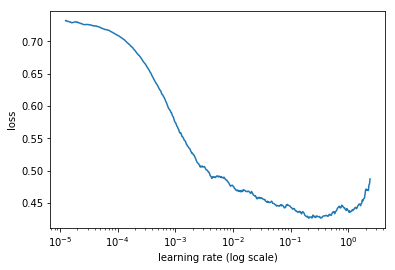

In [425]:
%matplotlib inline
learn.sched.plot()

In [426]:
lr = 0.1
learn.fit(lr, 10, wds= 1e-3)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

 45%|████▍     | 279/625 [00:06<00:07, 45.02it/s, loss=0.426]

Exception in thread Thread-70:
Traceback (most recent call last):
  File "/home/kerem/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/kerem/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                               
    0      0.412079   0.420601  
    1      0.416834   0.416015                               
    2      0.412063   0.415178                               
    3      0.409337   0.423411                               
 30%|██▉       | 186/625 [00:04<00:10, 43.56it/s, loss=0.408]


KeyboardInterrupt: 

 30%|██▉       | 186/625 [00:20<00:47,  9.29it/s, loss=0.408]